# 学習パラメータの読み込みと推論

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np

In [3]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)

In [4]:
model_path = 'model_ft_gpu.pth'
model_ft.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'potato'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

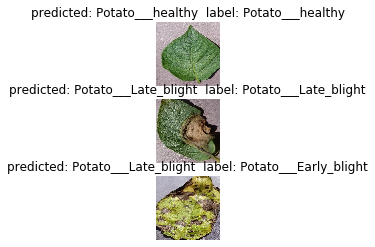

In [6]:
def tensor_to_np(inp):
  "imshow for Tensor"
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  return inp

def visualize_model(model, num_images=3):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = fig.add_subplot(num_images, 1, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}  label: {}'
                             .format(class_names[preds[j]], class_names[labels[j]]))
                ax.imshow(tensor_to_np(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)

In [7]:
labels = []
datas = []
for i, (data, label) in enumerate(dataloaders['val']):
    labels.append(label.cuda())
    datas.append(data.cuda())
len(datas)

300

In [8]:
model_ft.eval()
# x, y = image_datasets['val'][0][0], image_datasets['val'][0][1]
passed = 0
for i in range(len(datas)):
    x, y = datas[i], labels[i]
    with torch.no_grad():
        pred = model_ft(x)
        predicted, actual = class_names[pred[0].argmax(0)], class_names[y]
        # print(f'Predicted: "{predicted}", Actual: "{actual}"')
        if predicted==actual:
            passed += 1
print(f"accuracy:{passed/len(datas)}")

accuracy:0.8033333333333333


# 未知データでの評価（Test data）

In [15]:
data_transforms = {
    'test': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'potato'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}

In [17]:
labels = []
datas = []
for i, (data, label) in enumerate(dataloaders['test']):
    labels.append(label.cuda())
    datas.append(data.cuda())
len(datas)

300

In [18]:
model_ft.eval()
passed = 0
preds = []
actuals = []
for i in range(len(datas)):
    x, y = datas[i], labels[i]
    with torch.no_grad():
        pred = model_ft(x)
        predicted, actual = class_names[pred[0].argmax(0)], class_names[y]
        preds.append(predicted)
        actuals.append(actual)
        #print(f'Predicted: "{predicted}", Actual: "{actual}"')
        if predicted==actual:
            passed += 1
print(f"accuracy:{passed/len(datas)}")

accuracy:0.7333333333333333


In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(actuals, preds)
print(cm)

[[ 41  45  14]
 [  2  79  19]
 [  0   0 100]]


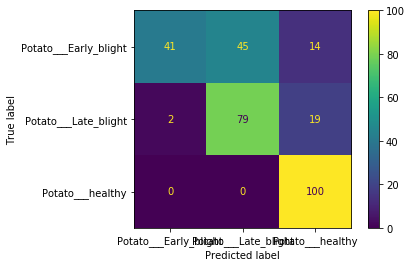

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot()

# 未知データでの評価（外部データ）

In [22]:
data_transforms = {
    'val': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'gaibu'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['val']}

In [23]:
labels = []
datas = []
for i, (data, label) in enumerate(dataloaders['val']):
    labels.append(label.cuda())
    datas.append(data.cuda())
len(datas)

530

In [24]:
model_ft.eval()
passed = 0
preds = []
actuals = []
for i in range(len(datas)):
    x, y = datas[i], labels[i]
    with torch.no_grad():
        pred = model_ft(x)
        predicted, actual = class_names[pred[0].argmax(0)], class_names[y]
        preds.append(predicted)
        actuals.append(actual)
        #print(f'Predicted: "{predicted}", Actual: "{actual}"')
        if predicted==actual:
            passed += 1
print(f"accuracy:{passed/len(datas)}")

accuracy:0.7981132075471699


[[ 52  36  12]
 [  0  46  21]
 [ 11  27 325]]


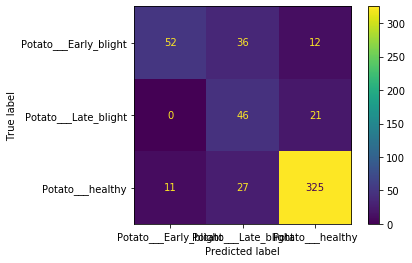

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(actuals, preds)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot()

In [35]:
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score

print(accuracy_score(actuals, preds))
print(precision_score(actuals, preds,average='micro'))
print(recall_score(actuals, preds,average='micro'))
print(f1_score(actuals, preds,average='micro'))

0.7981132075471699
0.7981132075471699
0.7981132075471699
0.79811320754717
